In [0]:
# import all necessary packages
import matplotlib.pyplot as plt # plotting
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import sys

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1hyI0ADwdQbC-HxJi64NzykwuCyt9_PwB'
fluff, id = link.split('=')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('KDD_NA.csv')

In [17]:
# Data cleaning and enhancing

# read data
data = pd.read_csv('KDD_NA.csv', sep= ',', header= 0, nrows=50000)

# remove the columns which have no unique elements
data = data[[col for col in data if data[col].nunique() > 1]]

# Convert the columns of non numerical type to numerical type
data['label_factor'] = data['label'].factorize()[0]
data.label_factor[data.label_factor>0]=1
data['protocol_type_factor'] = data['protocol_type'].factorize()[0]
data['service_factor'] = data['service'].factorize()[0]
data['flag_factor'] = data['flag'].factorize()[0]

# Reindex the dataframe such that 1st column is target column
column_names = ['label_factor', 'duration', 'protocol_type_factor', 'service_factor', 'flag_factor', 'src_bytes', 'dst_bytes', 'hot', 'logged_in',
                'lnum_compromised', 'lroot_shell', 'lnum_root', 'lnum_file_creations', 'lnum_shells', 'lnum_access_files', 'is_guest_login', 'count', 
                'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
                'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
                'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
data=data.reindex(columns=column_names)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,label_factor,duration,protocol_type_factor,service_factor,flag_factor,src_bytes,dst_bytes,hot,logged_in,lnum_compromised,lroot_shell,lnum_root,lnum_file_creations,lnum_shells,lnum_access_files,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,0,0,0,0,181,5450,0,1,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,239,486,0,1,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,235,1337,0,1,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,219,1337,0,1,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,217,2032,0,1,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


In [18]:
# Store the entries of the dataset except target column
X=data.reindex(columns=column_names[1:])

# Preprocess the data to normalize the dataset
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

# Assign the target column to a variable
Y=data['label_factor']

# Split the datase into training and testing dataset
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X,Y, data.index, test_size=0.2, random_state=0)
print('Data size of training set:',len(X_train))
print('Data size of testing set:',len(X_test))

Data size of training set: 40000
Data size of testing set: 10000


In [19]:
# Support Vector Classifier
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
y_pred_LSVC = lsvc.fit(X_train, y_train).predict(X_test)
print("Accuracy of SVC: ", metrics.accuracy_score(y_test,y_pred_LSVC)*100)

Accuracy of SVC:  99.72


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [20]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 0,
                               min_samples_split =3)
clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 0,
                               min_samples_split =3)
y_pred_DTC_gini = clf_gini.fit(X_train, y_train).predict(X_test)
y_pred_DTC_entropy = clf_entropy.fit(X_train, y_train).predict(X_test)
print("Accuracy of DTC (gini): ", metrics.accuracy_score(y_test,y_pred_DTC_gini)*100)
print("Accuracy of DTC (entropy):", metrics.accuracy_score(y_test,y_pred_DTC_entropy)*100)


Accuracy of DTC (gini):  99.91
Accuracy of DTC (entropy): 99.97


In [21]:
#KNN
knn = KNeighborsClassifier()
y_pred_knn = knn.fit(X_train, y_train).predict(X_test)
print("Accuracy of KNN:",metrics.accuracy_score(y_test, y_pred_knn)*100)

Accuracy of KNN: 99.95


In [22]:
# AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=100, random_state=0)
y_pred_abc = abc.fit(X_train, y_train).predict(X_test)
print("Accuracy of AdaBoost Classifier:", metrics.accuracy_score(y_test, y_pred_knn)*100)

Accuracy of AdaBoost Classifier: 99.95


In [23]:
# XGBoost Classifier
import xgboost as xgb
from xgboost import XGBClassifier
xb = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

y_pred_xb =  xb.fit(X_train, y_train, eval_metric='auc').predict(X_test)
print("Accuracy of XGBoost Classifier:", metrics.accuracy_score(y_test, y_pred_xb)*100)

Accuracy of XGBoost Classifier: 99.96000000000001


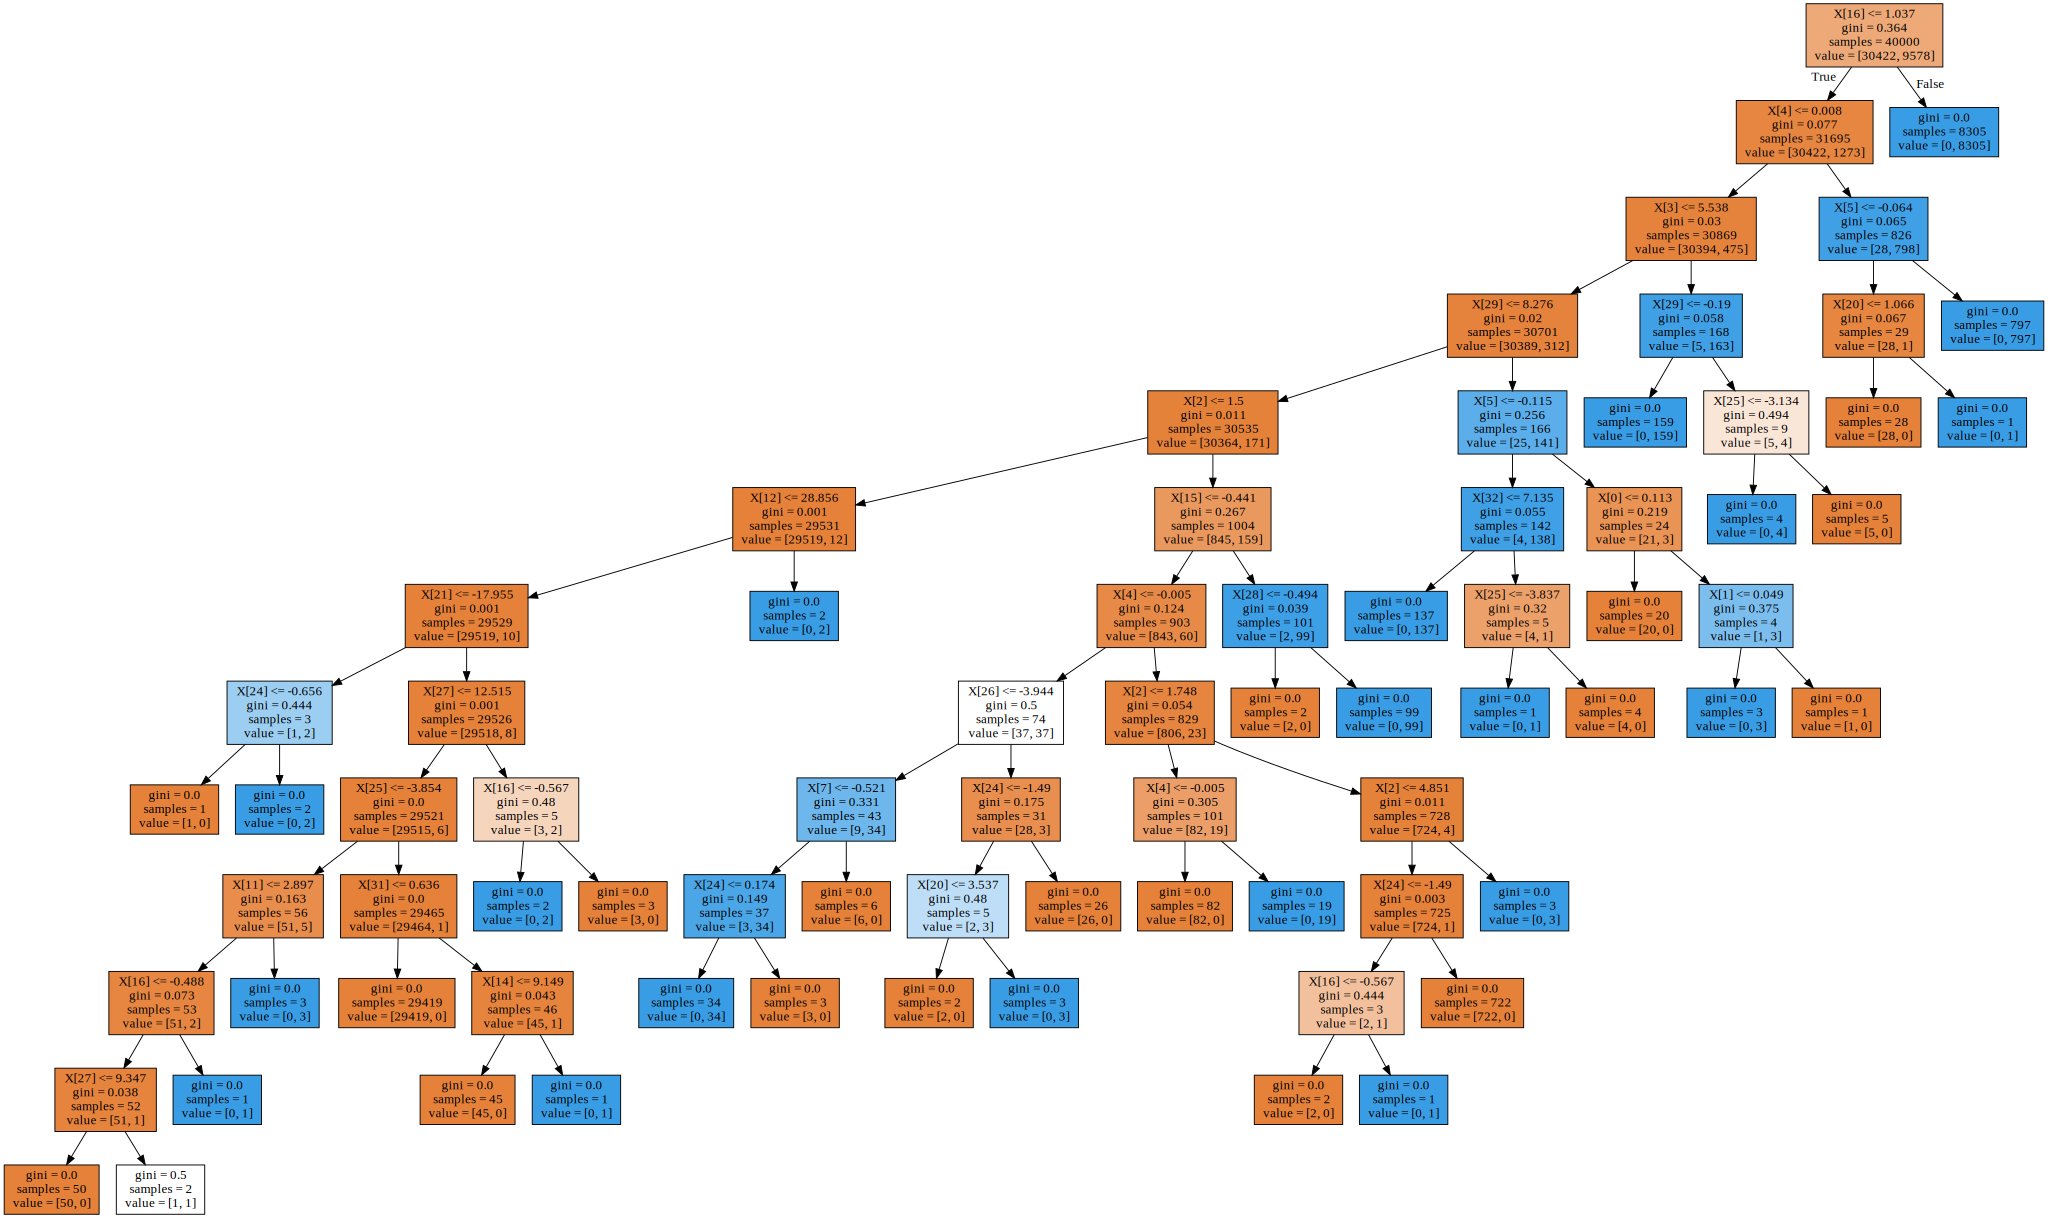

In [24]:
 # DTC gini decision tree image:
plt.rcParams['figure.figsize'] = [20,20]
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
graph = Source(tree.export_graphviz(clf_gini.fit(X_train, y_train), out_file=None, filled = True))
display(SVG(graph.pipe(format='svg')))

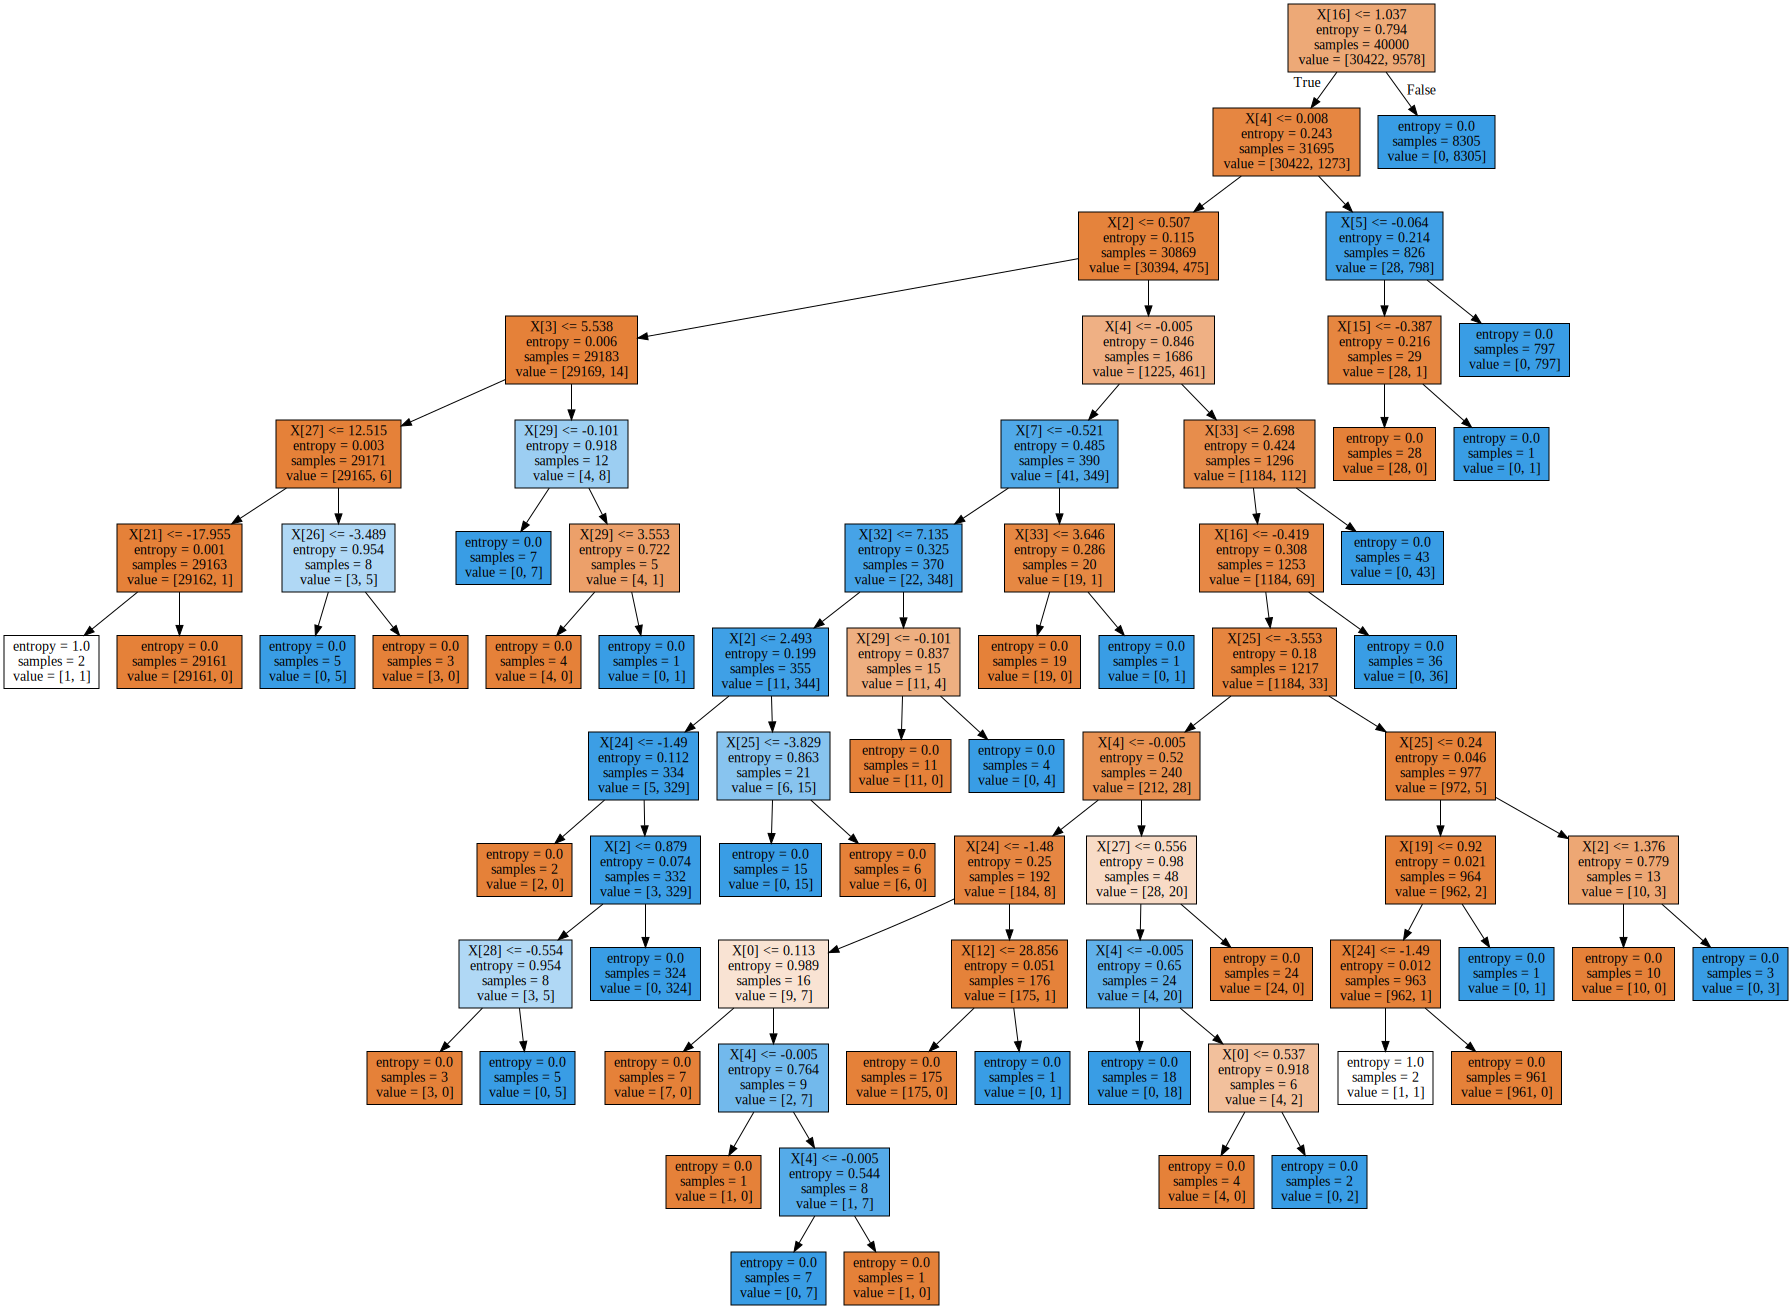

In [25]:
graph = Source(tree.export_graphviz(clf_entropy.fit(X_train, y_train), out_file=None, filled = True))
display(SVG(graph.pipe(format='svg')))